In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import descartes
#import pandas_profiling as pp
from geopandas.tools import overlay
from matplotlib import colors

In [2]:
data_file_crime = "Data/Chi_Crimes2018_Food.csv"
chicago_crime = pd.read_csv(data_file_crime)
chicago_crime_gdf = geopandas.GeoDataFrame(
    chicago_crime, geometry=geopandas.points_from_xy(chicago_crime.Longitude, chicago_crime.Latitude))
chicago_crime_gdf.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,geometry
0,11553488,JC101094,12/31/2018 23:45,032XX N SHEFFIELD AVE,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,"(41.940518859, -87.6541242)",38.0,"4,449",57.0,731.0,25.0,22.0,5.0,28.0,POINT (-87.65412420000001 41.94051886)


In [3]:
chicago_neighborhoods = geopandas.read_file("Data/geo_export_a7b0c29f-14bd-45d7-a251-f4277387b6a6.geojson")
chicago_neighborhoods.head(1)

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,POLYGON ((-87.60670812560372 41.81681377137392...


In [4]:
chicago_census = geopandas.read_file("Data/Boundaries - Census Tracts - 2010.geojson")
#chicago_census.profile_report(style={'full_width':True})

In [5]:
chicago_census = chicago_census.rename(columns={"geoid10": "CENSUS_TRACT"})
chicago_census["CENSUS_TRACT"] = chicago_census["CENSUS_TRACT"].astype(np.int64)
chicago_census.head(1)

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...


In [6]:
grocery_path = "Data/Map_of_Grocery_Stores_-_2013.csv"
chicago_groceries = pd.read_csv(grocery_path)
chicago_groceries = chicago_groceries.rename(columns={"CENSUS TRACT": "CENSUS_TRACT"})

In [7]:
fastfood_path = "Data/fast_food_chicago.csv"
chicago_fast_food = pd.read_csv(fastfood_path)
#fast_food_count = chicago_fast_food.groupby("CENSUS_TRACT").count()
#fast_food_merge = fast_food_count["STORE NAME"]
#fast_food_merge.head()
#fast_food_df = pd.DataFrame(fast_food_merge)
#df_merge = chicago_fast_food.merge(fast_food_merge, how="left", on="CENSUS_TRACT")
#chicago_fast_food.columns

In [8]:
grocery_group = chicago_groceries.groupby("CENSUS_TRACT").count()
grocery_count = grocery_group["STORE NAME"]
chicago_full = chicago_census.merge(grocery_count, how="left", on="CENSUS_TRACT")
chicago_full = chicago_full.fillna(0)

In [9]:
chicago_full["Desert"] = np.where(chicago_full["STORE NAME"]>0, 'Not a Food Desert', 'Food Desert')
chicago_full.head()

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry,STORE NAME,Desert
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...,3.0,Not a Food Desert
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...,1.0,Not a Food Desert
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...,3.0,Not a Food Desert
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...,0.0,Food Desert
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...,0.0,Food Desert


In [10]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

In [11]:
#chicago_union = geopandas.overlay(chicago_neighborhoods, chicago_full, how="union")
#chicago_union.plot(color='#3B3C6E')

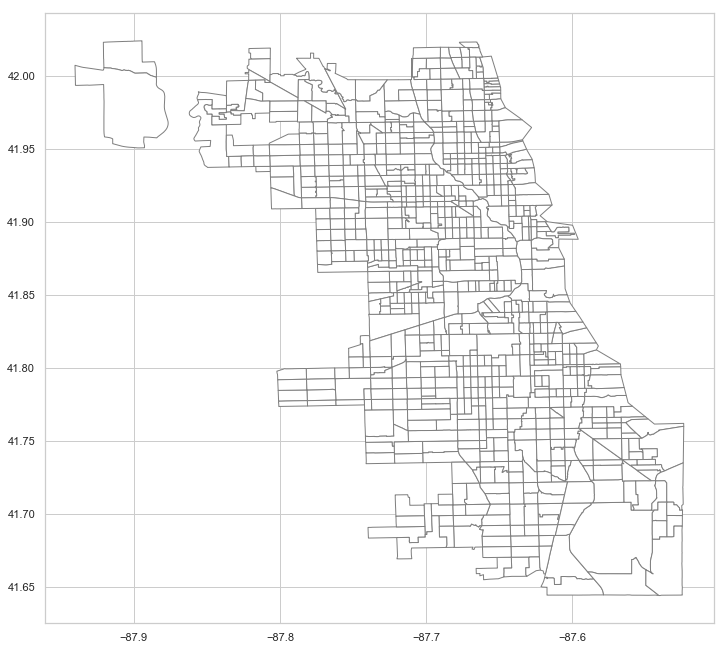

In [12]:
ax = chicago_census.plot(color="white", edgecolor="grey", figsize=(12, 12))

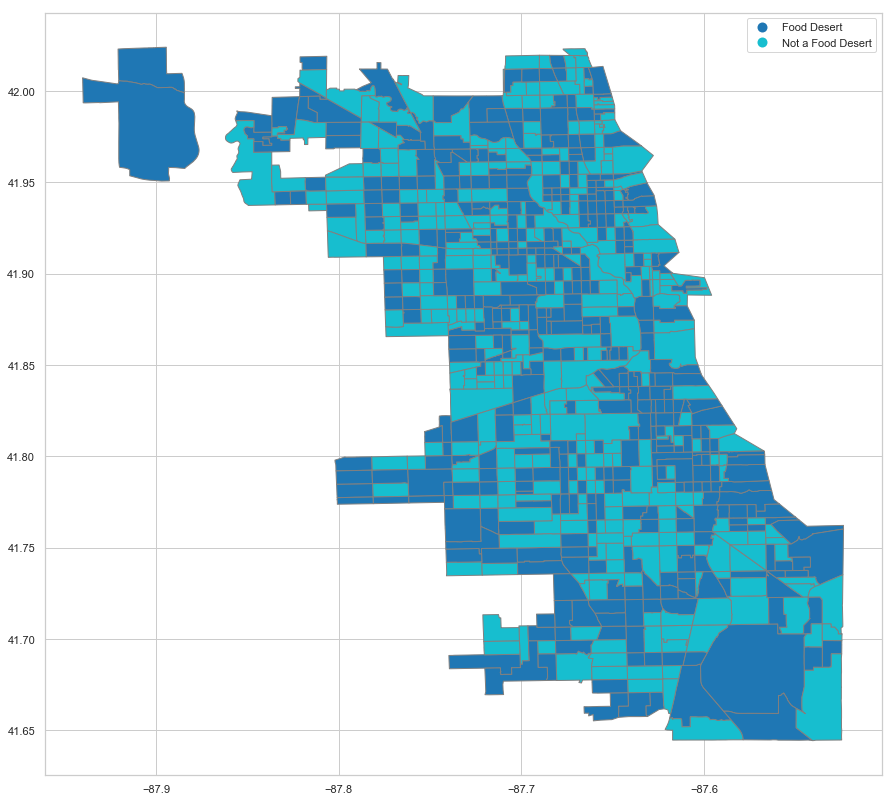

In [13]:
fig, ax = plt.subplots(1, figsize=(15,15))
chicago_full.plot(ax = ax, column="Desert", legend=True, edgecolor="grey")
#chicago_crime_gdf.plot(ax=ax, marker="o", color="red", markersize=.5)

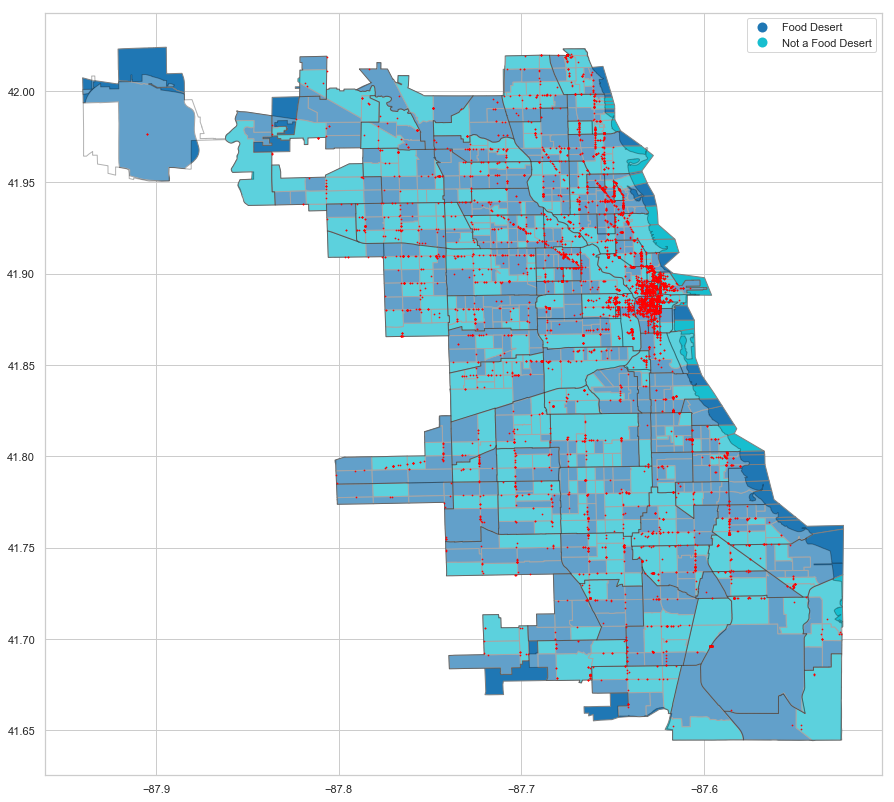

In [14]:
fig, ax = plt.subplots(1, figsize=(15,15))
chicago_full.plot(ax = ax, column="Desert", legend=True, edgecolor="grey")
chicago_neighborhoods.plot(ax=ax, alpha=0.3, color="white", edgecolor="black");
chicago_crime_gdf.plot(ax=ax, marker="o", color="red", markersize=.5)